<a href="https://colab.research.google.com/github/SAYEDASHRAF1218/CODSOFT.1/blob/main/moviefinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Sample training data:
   ID                             Title    genres  \
0   1      Oscar et la dame rose (2009)     drama   
1   2                      Cupid (1997)  thriller   
2   3  Young, Wild and Wonderful (1980)     adult   
3   4             The Secret Sin (1915)     drama   
4   5            The Unrecovered (2007)     drama   

                                                plot  
0  Listening in to a conversation between his doc...  
1  A brother and sister with a past incestuous re...  
2  As the bus empties the students for their fiel...  
3  To help their unemployed father make ends meet...  
4  The film's title refers not only to the un-rec...  

🔹 Training Logistic Regression...

📌 Results for Logistic Regression on Validation Set:
Accuracy: 0.351378769713179
              precision    recall  f1-score   support

      action       0.83      0.07      0.13       263
       adult       0.90      0.08      0.15       112
   adventure       0.57      0.03      0.05      

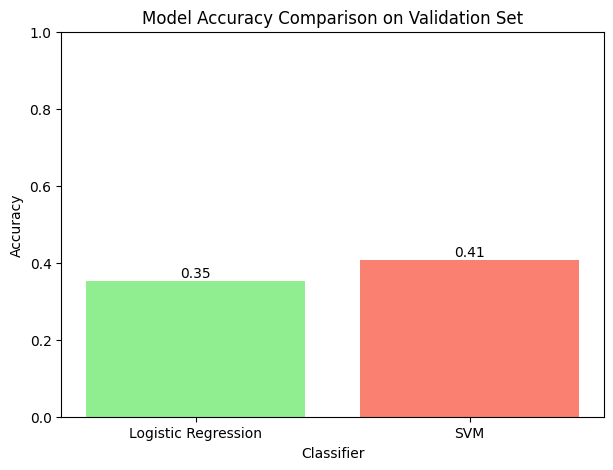


🔮 Sample Predictions:

Logistic Regression Predictions:
  Plot: A young boy discovers he has magical powers and attends a wizarding school.
  Predicted Genres: ()

  Plot: A detective investigates a mysterious murder in a small town.
  Predicted Genres: ('mystery',)


SVM Predictions:
  Plot: A young boy discovers he has magical powers and attends a wizarding school.
  Predicted Genres: ('drama',)

  Plot: A detective investigates a mysterious murder in a small town.
  Predicted Genres: ('mystery', 'thriller')



In [9]:
# 📌 Movie Genre Prediction with Multiple Classifiers + Visualization
# Internship Task - Genre Classification from Plot Summaries

import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score # Added roc_auc_score
from sklearn.multiclass import OneVsRestClassifier # Import OneVsRestClassifier

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# -------------------------------
# 1. Load Dataset
# -------------------------------
# Correctly load data by specifying the delimiter and column names
train_data = pd.read_csv("train_data.txt", sep=" ::: ", names=["ID", "Title", "genres", "plot"], engine="python")
test_data = pd.read_csv("test_data.txt", sep=" ::: ", names=["ID", "Title", "plot"], engine="python")

print("Sample training data:")
print(train_data.head())

# -------------------------------
# 2. Preprocess Text
# -------------------------------
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(r"[^a-zA-Z]", " ", str(text))  # remove non-letters
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return " ".join(text)

train_data["clean_plot"] = train_data["plot"].apply(preprocess)
test_data["clean_plot"] = test_data["plot"].apply(preprocess)

# -------------------------------
# 3. Encode Genres (Multi-label)
# -------------------------------
mlb = MultiLabelBinarizer()
# Ensure genres column is treated as a list of strings
train_data["genres"] = train_data["genres"].apply(lambda x: x.split(","))
# For test data, genres are not available in test_data.txt, so we'll skip this for now
# test_data["genres"] = test_data["genres"].apply(lambda x: x.split(","))

y_train = mlb.fit_transform(train_data["genres"])
# We don't have true y_test labels from test_data.txt for evaluation on a separate test set loaded from this file directly
# y_test = mlb.transform(test_data["genres"])

# -------------------------------
# 4. TF-IDF Vectorization
# -------------------------------
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_data["clean_plot"])
X_test = vectorizer.transform(test_data["clean_plot"]) # Use test_data for sample predictions later

# -------------------------------
# 5. Train & Evaluate Multiple Models
# -------------------------------
models = {
    # "Naive Bayes": MultinomialNB(), # MultinomialNB is not suitable for multi-label classification
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=200)), # Wrap with OneVsRestClassifier
    "SVM": OneVsRestClassifier(LinearSVC()) # Wrap with OneVsRestClassifier
}

accuracies = {} # Keep accuracies for visualization

# We will train and evaluate on a validation split of the training data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_val_split)

    acc = accuracy_score(y_val_split, y_pred)
    accuracies[name] = acc

    print(f"\n📌 Results for {name} on Validation Set:")
    print("Accuracy:", acc)
    # Handle potential empty target names in classification_report
    target_names = mlb.classes_ if len(mlb.classes_) > 0 else ['Unknown']
    print(classification_report(y_val_split, y_pred, target_names=target_names, zero_division=0))

# Calculate ROC AUC for models that support probability prediction (Logistic Regression)
for name, model in models.items():
  if hasattr(model, "predict_proba"):
    y_pred_proba = model.predict_proba(X_val_split)
    # roc_auc_score requires probability estimates, use multi-label friendly average
    print(f"\n📌 ROC AUC for {name} on Validation Set:")
    print(roc_auc_score(y_val_split, y_pred_proba, average='weighted')) # Use weighted average for multi-label


# -------------------------------
# 6. Visualization - Accuracy Comparison
# -------------------------------
plt.figure(figsize=(7,5))
plt.bar(accuracies.keys(), accuracies.values(), color=["lightgreen","salmon"]) # Updated colors
plt.title("Model Accuracy Comparison on Validation Set") # Updated title
plt.ylabel("Accuracy")
plt.xlabel("Classifier")
plt.ylim(0, 1)  # Accuracy between 0 and 1
for i, acc in enumerate(accuracies.values()):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha="center")
plt.show()

# -------------------------------
# 7. Sample Predictions
# -------------------------------
sample_texts = [
    "A young boy discovers he has magical powers and attends a wizarding school.",
    "A detective investigates a mysterious murder in a small town."
]

sample_clean = [preprocess(text) for text in sample_texts]
sample_features = vectorizer.transform(sample_clean)

print("\n🔮 Sample Predictions:")
for name, model in models.items():
    preds = model.predict(sample_features)
    # Inverse transform predictions, handling potential empty predictions
    preds_genres = mlb.inverse_transform(preds) if len(mlb.classes_) > 0 else [["Unknown"] for _ in range(len(preds))]

    print(f"\n{name} Predictions:")
    for text, pred in zip(sample_texts, preds_genres):
        print(f"  Plot: {text}\n  Predicted Genres: {pred}\n")